In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.table import Table
import math as m
from sympy import symbols, solve, Eq
import emcee

import pymc
import arviz
import corner

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [26]:
# some code for prettier plots
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 16,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6),
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 8,
                     'ytick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.minor.size': 4})

In [128]:
# open systems data
systems  = pd.read_csv("table2_systems.csv")
systems  = systems[(systems["Type"] == "G") & (systems["sigma"] > 0) & (systems["N_mem"] > 10)] # only keep dgs
systems = systems.reset_index(drop = True)
systems["Galaxy_idx"] = np.arange(0, len(systems))

# galaxy names
galaxies = np.unique(systems["Name2"])
gal_idx  = {name: i for i, name in enumerate(galaxies)}

# open stars data, only keep dgs
stars = pd.read_csv("table4_stars.csv")
stars = stars[stars["Galaxy"].isin(galaxies)]
stars["Galaxy_idx"] = np.array([gal_idx[ii] for ii in stars["Galaxy"]])

# open multi-epoch data, only keep dgs
stars_multiple_tab = Table.read("KOA_table_one_row_per_star_per_mask.fits")
stars_multiple     = stars_multiple_tab.to_pandas()
stars_multiple['system_name'] = stars_multiple['system_name'].str.decode('utf-8')
stars_multiple     = stars_multiple[stars_multiple["system_name"].isin(galaxies)]
stars_multiple["Galaxy_idx"] = np.array([gal_idx[ii] for ii in stars_multiple["system_name"]])

print(len(galaxies))

27


In [129]:
stars_multiple.columns

Index(['system_name', 'maskname', 'mask_mjd', 'nmask', 'slitname', 'objname',
       'RA', 'DEC', 'phot_source', 'gmag_o', 'rmag_o', 'gmag_err', 'rmag_err',
       'MV_o', 'mask_SN', 'mask_teff', 'mask_serendip', 'mask_coadd_flag',
       'mask_marz_flag', 'mask_v', 'mask_v_err', 'mask_marz_z', 'mask_ew_cat',
       'mask_ew_cat_err', 'mask_ew_naI', 'mask_ew_naI_err', 'mask_ew_mgI',
       'mask_ew_mgI_err', 'mask_ew_feh', 'mask_ew_feh_err', 'flag_HB',
       'mask_collate1d_filename', 'Galaxy_idx'],
      dtype='object')

In [130]:
stars.columns

Index(['Galaxy', 'RA', 'DEC', 'r', 'gr', 'nmask', 't_exp', 'SN', 'v', 'verr',
       'CaT', 'CaTerr', 'FeH', 'FeH_err', 'Var', 'Pmem', 'Galaxy_idx'],
      dtype='object')

In [131]:
systems.columns

Index(['Name', 'Name2', 'RA', 'Dec', 'Dist', 'MV', 'R_eff', 'Type', 'Phot',
       'N_mask', 'N_mem', 'vhel', 'vhelerr', 'sigma', 'serr_low', 'serr_up',
       'serr_95', 'Galaxy_idx'],
      dtype='object')

### Empirical distributions

Text(0, 0.5, 'Number of DGs')

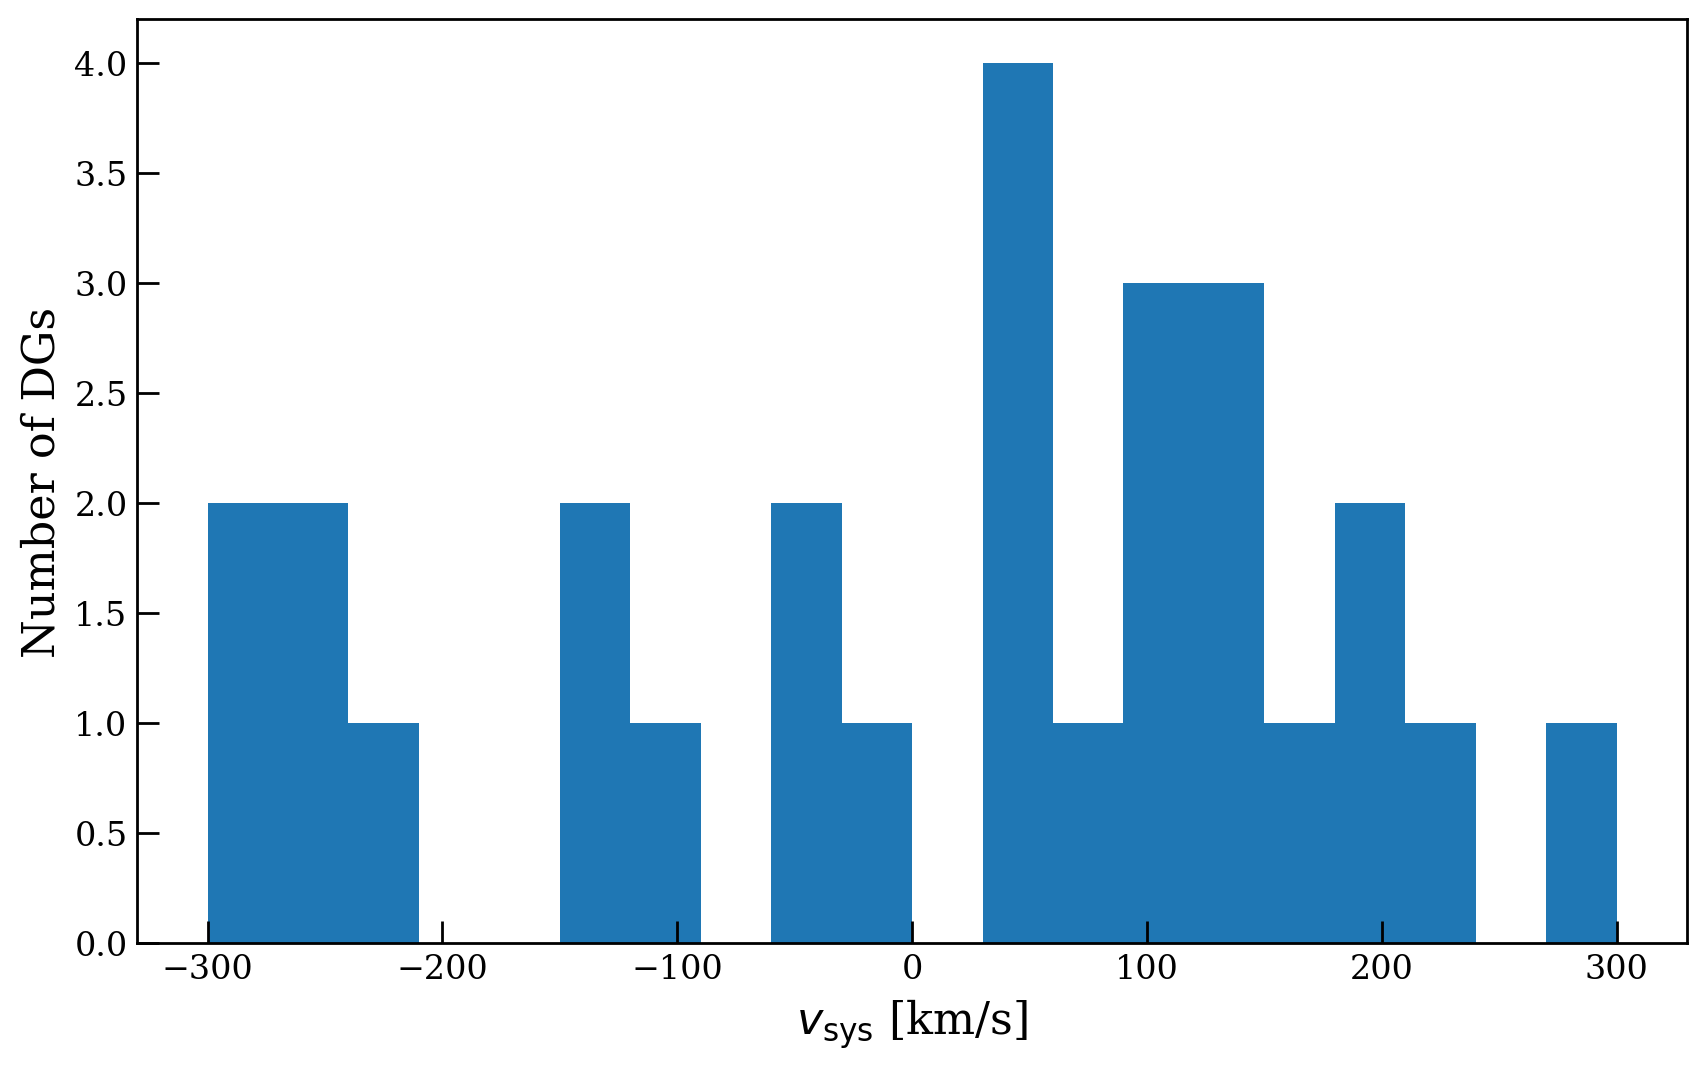

In [132]:
plt.hist(systems["vhel"], range = [-300, 300], bins = 20)
plt.xlabel(r"$v_{\rm sys}$ [km/s]")
plt.ylabel("Number of DGs")

Text(0, 0.5, 'Number of DGs')

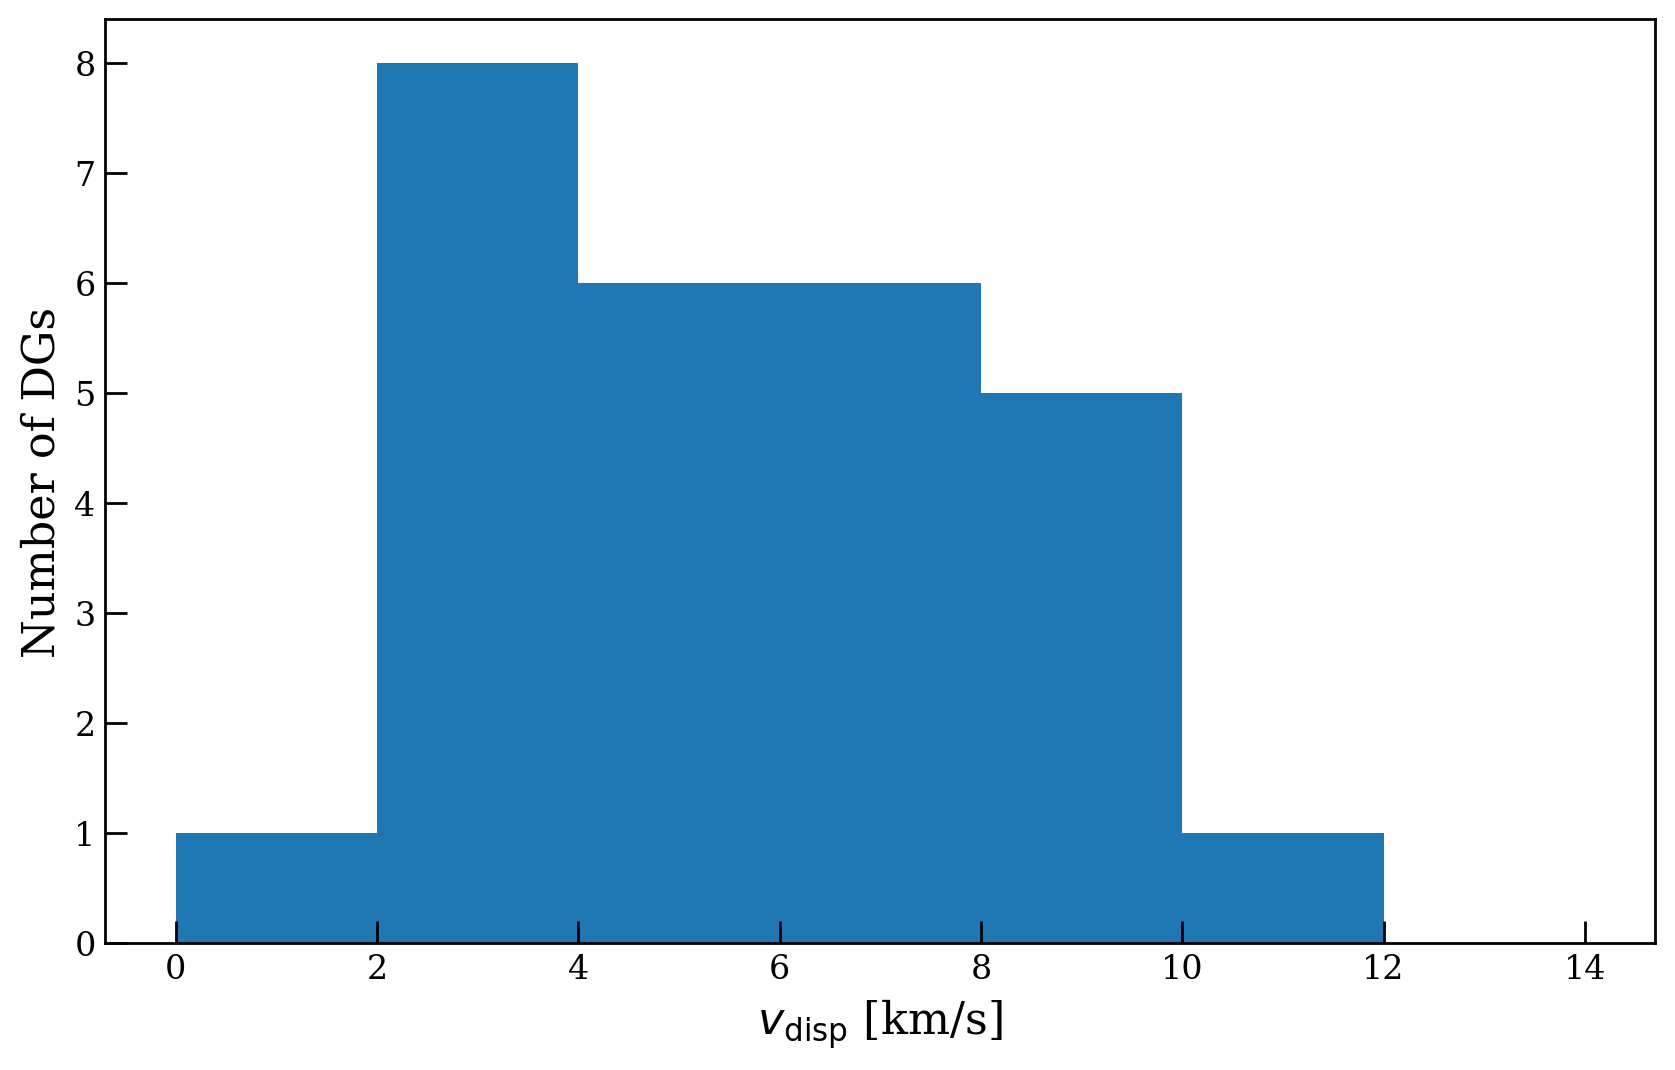

In [133]:
plt.hist(systems["sigma"], range = [0, 14], bins = 7)
plt.xlabel(r"$v_{\rm disp}$ [km/s]")
plt.ylabel("Number of DGs")

### Data wrangling

In [134]:
### add in elliptical half-light ??? add in probability ??? check matching

In [135]:
for gg in galaxies:
    # get system info
    row = systems[systems["Name2"] == gg]
    ra, dec, rhalf = row["RA"].values[0], row["Dec"].values[0], row["R_eff"].values[0] / 60

    # get stars in system
    s_rows = stars[stars["Galaxy"] == gg]
    x_ra = (s_rows["RA"].values - ra) * np.cos(np.deg2rad(dec))
    y_dec = (s_rows["DEC"].values - dec)
    r = (x_ra ** 2 + y_dec ** 2) ** (1/2)
    n_rhalf = r / rhalf
    
    stars.loc[stars["Galaxy"] == gg, "rhalf"] = n_rhalf
    stars.loc[stars["Galaxy"] == gg, "s_idx"] = np.arange(0, len(s_rows))

In [136]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# astropy coordinates of munoz, full deimos data
c_phot = SkyCoord(stars_multiple["RA"], stars_multiple["DEC"], unit = u.degree)
c_deimos = SkyCoord(stars["RA"], stars["DEC"], unit = u.degree)

# matching criteria within 1 arcsec
index, d2d, d3d = c_phot.match_to_catalog_sky(c_deimos)
foo = np.arange(0, np.size(index), 1)
match_phot = foo[d2d < 1.*u.arcsec]
match_deimos = index[d2d < 1.*u.arcsec]

# new df with matched munoz/full deimos data
phot_data_match = stars_multiple.iloc[match_phot]
deimos_data_match = stars.iloc[match_deimos]
deimos_phot_combined = pd.concat([phot_data_match, deimos_data_match.set_axis(phot_data_match.index)], axis = 1)

print("{} matches out of {} deimos sources.".format(len(deimos_phot_combined), len(stars_multiple)))

12732 matches out of 14476 deimos sources.


In [137]:
stars_epochs = deimos_phot_combined[["Galaxy", "RA", "DEC", "r", "gr", "v", "verr", "FeH", "FeH_err", "Var", "Pmem", "Galaxy_idx", "rhalf", "s_idx"]]

### 1. Regular MCMC of individual galaxy

In [138]:
def velocity_mcmc(vel, vel_err, vr_guess, sig_guess, draws = 5000, tune = 2000):
    with pymc.Model() as model:
        # set priors
        v_r = pymc.Uniform("v_r", lower = -400, upper = 400, initval = vr_guess)
        log_sigma_v = pymc.Uniform("log_sigma_v", lower = np.log(0.1), upper = np.log(20), initval = np.log(sig_guess))
        sigma_v = pymc.Deterministic("sigma_v", pymc.math.exp(log_sigma_v))

        # set likelihood
        total_err = np.sqrt(vel_err**2 + sigma_v**2)
        pymc.Normal("obs", mu = v_r, sigma = total_err, observed = vel)

        # sample
        trace = pymc.sample(draws = draws, tune = tune, chains = 4, target_accept = 0.9, 
                            return_inferencedata = True, progressbar = True)

    # get summary and plot posterior
    summary = arviz.summary(trace, var_names=["v_r", "sigma_v"], hdi_prob = 0.68)
    arviz.plot_posterior(trace, var_names=["v_r", "sigma_v"], hdi_prob = 0.68)

    # plot corner
    sample_data = arviz.extract_dataset(trace, group = "posterior", var_names = ["v_r", "sigma_v"]).to_dataframe()
    fig = corner.corner(sample_data, labels = ["$v_r$", "$\sigma_v$"], quantiles = [0.16, 0.5, 0.84], 
                        show_titles = True, title_kwargs = {"fontsize": 12})
    plt.show()

    # get output
    posterior = arviz.extract_dataset(trace, group = "posterior", var_names = ["v_r", "sigma_v"]).to_dataframe()
    vr_vals = np.percentile(posterior["v_r"], [16, 50, 84])
    sigma_vals = np.percentile(posterior["sigma_v"], [16, 50, 84])

    return model, trace, summary, fig, vr_vals, sigma_vals

In [ ]:
for ii in range(len(galaxies)):
    gal_name = galaxies[ii]
    gal = stars[(stars["Galaxy"] == gal_name) & (stars["Pmem"] > 0.5) & (stars["Var"] != 1) & (stars["rhalf"] <= 2)]
    gal_global = systems[systems["Name2"] == gal_name]
    print(ii, len(gal), gal_global["vhel"].values, gal_global["sigma"].values)

    if len(gal) > 10:
        model, trace, summary, fig, vr_vals, sigma_vals = velocity_mcmc(gal["v"].values, gal["verr"].values, vr_guess = gal_global["vhel"].values[0], sig_guess = gal_global["sigma"].values[0])
    else:
        vr_vals, sigma_vals = [np.nan, np.nan, np.nan], [np.nan, np.nan, np.nan]
    
    systems.loc[ii, "vsys_1"]   = vr_vals[1]
    systems.loc[ii, "vsys_1ep"] = vr_vals[2] - vr_vals[1]
    systems.loc[ii, "vsys_1em"] = vr_vals[1] - vr_vals[0]

    systems.loc[ii, "vdisp_1"]   = sigma_vals[1]
    systems.loc[ii, "vdisp_1ep"] = sigma_vals[2] - sigma_vals[1]
    systems.loc[ii, "vdisp_1em"] = sigma_vals[1] - sigma_vals[0]

    systems.loc[ii, "Nstar"] = len(gal)

In [88]:
systems.to_csv("systems1.csv")

Leo5
14 11 [170.413] [3.466]


Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_r, log_sigma_v]
INFO:pymc.sampling.mcmc:NUTS: [v_r, log_sigma_v]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 40 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 40 seconds.
/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_14446/2734167876.py:21: FutureWarning: extract_dataset has been deprecated, please use extract
  sample_data = arviz.extract_dataset(trace, group = "posterior", var_names = ["v_r", "sigma_v"]).to_dataframe()


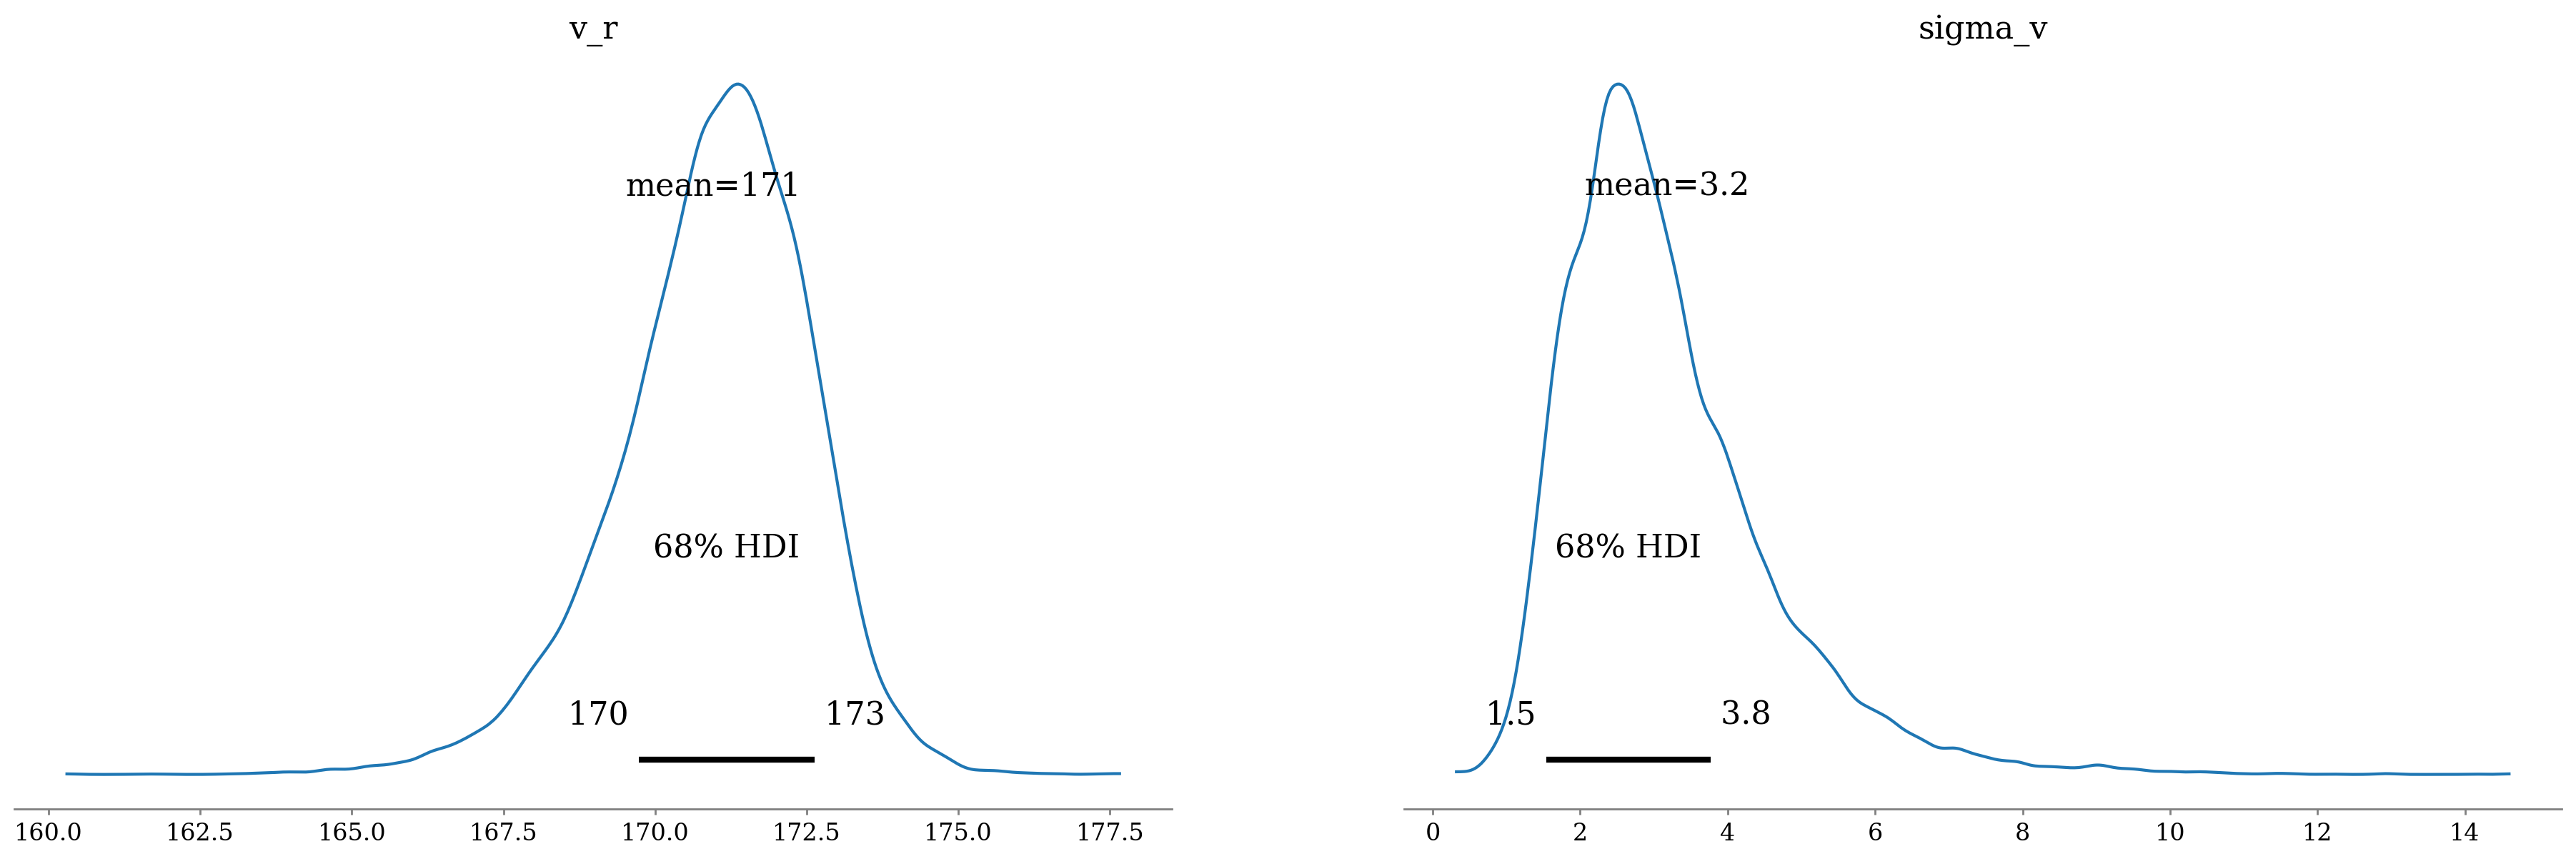

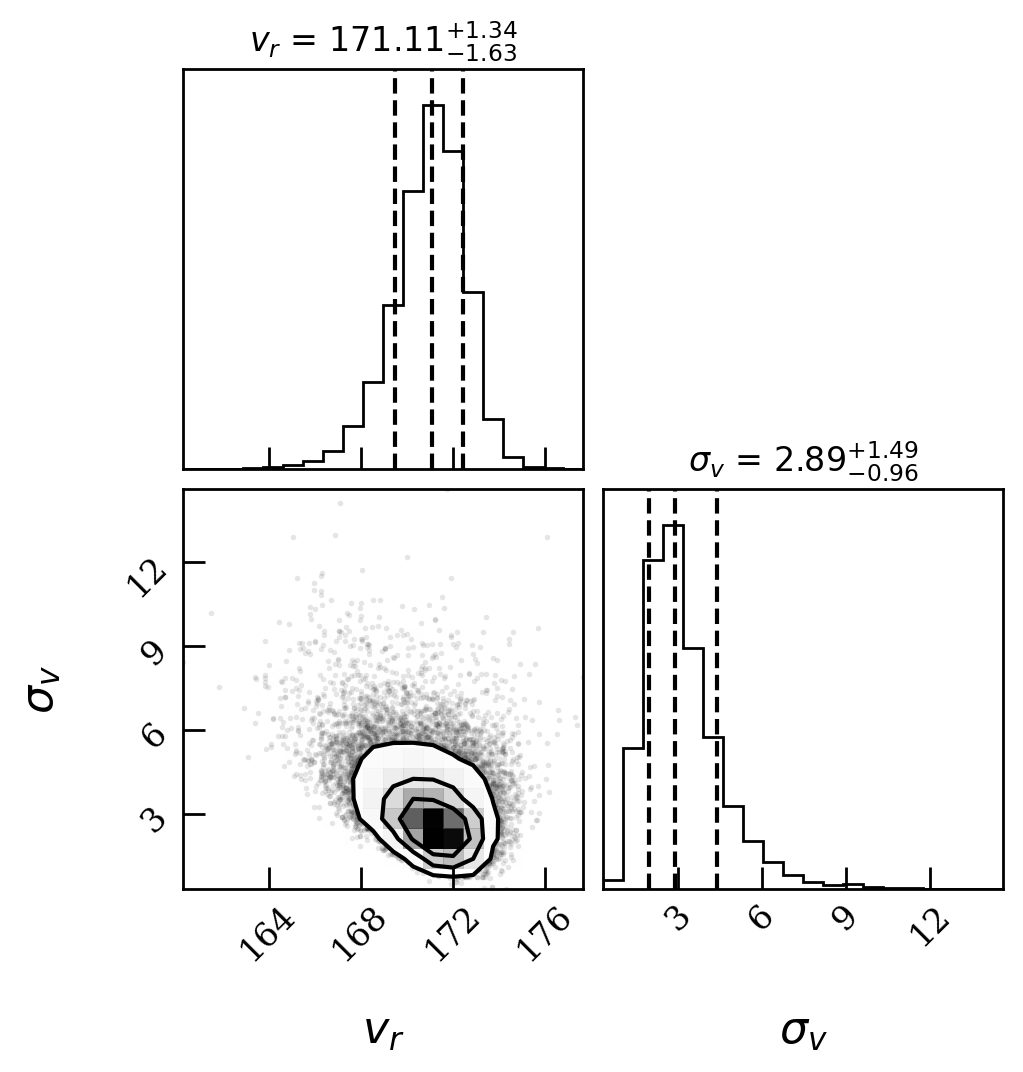

/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_14446/2734167876.py:27: FutureWarning: extract_dataset has been deprecated, please use extract
  posterior = arviz.extract_dataset(trace, group = "posterior", var_names = ["v_r", "sigma_v"]).to_dataframe()


In [146]:
for ii in [14]:
    gal_name = galaxies[ii]
    print(gal_name)
    gal = stars[(stars["Galaxy"] == gal_name) & (stars["Pmem"] > 0.5) & (stars["Var"] != 1) & (stars["rhalf"] <= 2)]
    gal_global = systems[systems["Name2"] == gal_name]
    print(ii, len(gal), gal_global["vhel"].values, gal_global["sigma"].values)

    if len(gal) > 10:
        model, trace, summary, fig, vr_vals, sigma_vals = velocity_mcmc(gal["v"].values, gal["verr"].values, vr_guess = gal_global["vhel"].values[0], sig_guess = gal_global["sigma"].values[0])
    
    else:
        vr_vals, sigma_vals = [np.nan, np.nan, np.nan], [np.nan, np.nan, np.nan]
    
    systems.loc[ii, "vsys_1"]   = vr_vals[1]
    systems.loc[ii, "vsys_1ep"] = vr_vals[2] - vr_vals[1]
    systems.loc[ii, "vsys_1em"] = vr_vals[1] - vr_vals[0]

    systems.loc[ii, "vdisp_1"]   = sigma_vals[1]
    systems.loc[ii, "vdisp_1ep"] = sigma_vals[2] - sigma_vals[1]
    systems.loc[ii, "vdisp_1em"] = sigma_vals[1] - sigma_vals[0]

    systems.loc[ii, "Nstar"] = len(gal)

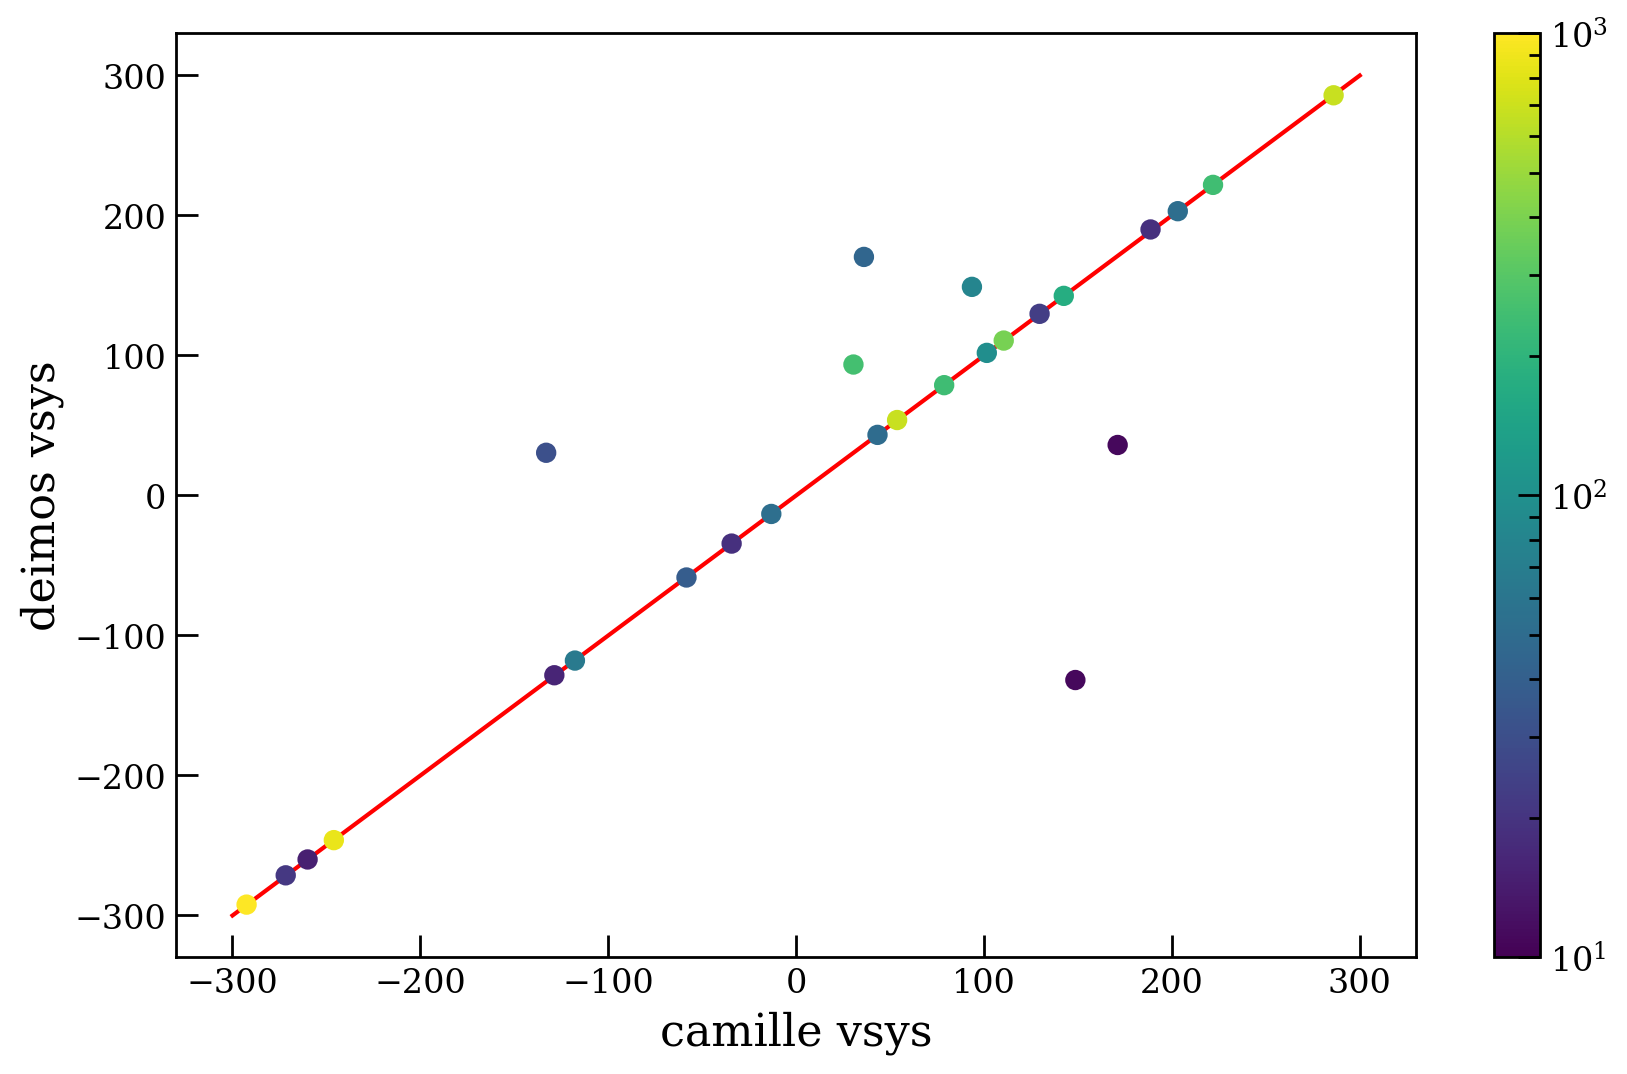

In [125]:
plt.errorbar(systems["vsys_1"], systems["vhel"], xerr = np.array([systems["vsys_1ep"], systems["vsys_1em"]]), 
             yerr = systems["vhelerr"], fmt = "o", c = "black", ms = 2, zorder = 0)
plt.scatter(systems["vsys_1"], systems["vhel"], c = systems["Nstar"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([-300, 300], [-300, 300], c = "red", zorder = 0)
plt.xlabel("camille vsys")
plt.ylabel("deimos vsys")
plt.colorbar()

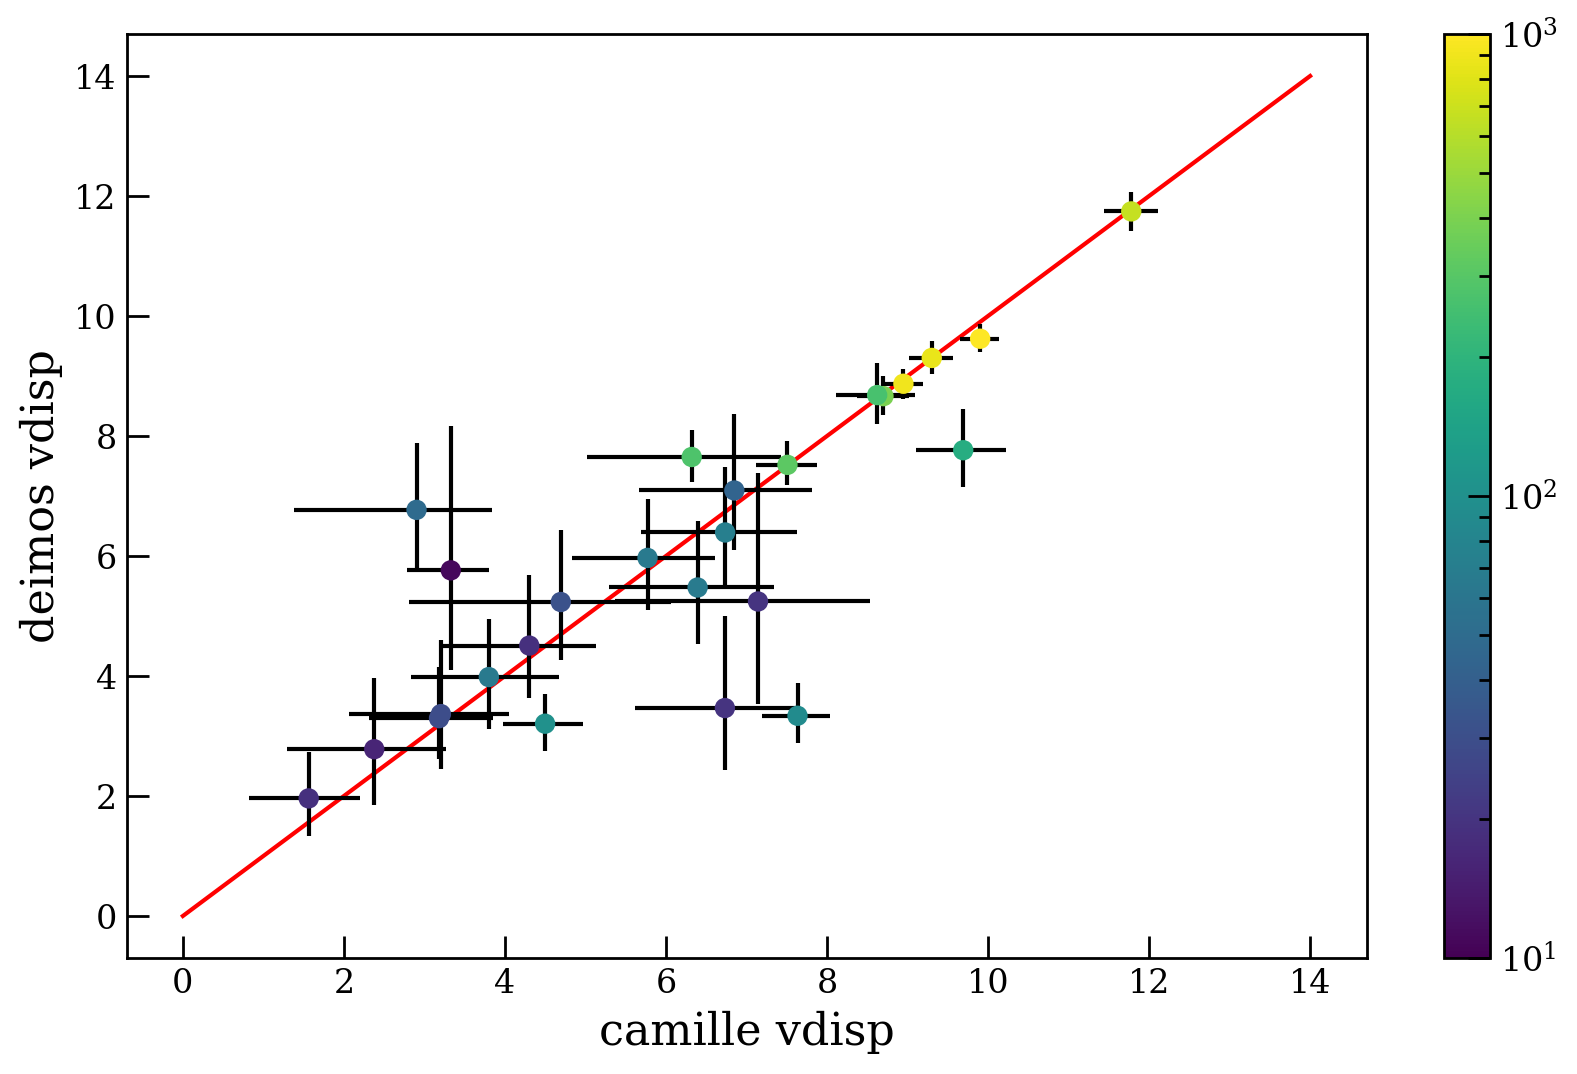

In [78]:
plt.errorbar(systems["vdisp_1"], systems["sigma"], xerr = np.array([systems["vdisp_1ep"], systems["vdisp_1em"]]), 
             yerr = np.array([systems["serr_low"], systems["serr_up"]]), fmt = "o", c = "black", ms = 2, zorder = 1)
plt.scatter(systems["vdisp_1"], systems["sigma"], c = systems["N_mem"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([0, 14], [0, 14], c = "red", zorder = 0)
plt.xlabel("camille vdisp")
plt.ylabel("deimos vdisp")
plt.colorbar()

### 2. Adding population level hyperpriors

In [ ]:
def velocity_mcmc2(vels, v_errs, galaxy_ids, draws = 4000, tune = 2000):
    n_galaxies = np.unique(galaxy_ids).size

    with pymc.Model() as model:
        # 1) Population hyperparameters
        mu_vr = pymc.Normal("mu_vr", mu = 0, sigma = 10)                     # mean of global systemic velocity distribution
        log_tau_vr = pymc.Uniform("log_tau_vr", lower = np.log(50), upper = np.log(200))
        tau_vr = pymc.Deterministic("tau_vr", pymc.math.exp(log_tau_vr))     # population scatter in global systemic velocity distribution

        mu_sig = pymc.TruncatedNormal("mu_sig", mu = 6, sigma = 2, lower = 0, upper = 15)    # mean of velocity dispersion distribution
        log_tau_sig = pymc.Uniform("log_tau_sig", lower = np.log(1), upper = np.log(10))   # population scatter in velocity dispersion distribution
        tau_sig = pymc.Deterministic("tau_sig", pymc.math.exp(log_tau_sig))

        # 2) Galaxy parameters
        v_r = pymc.Normal("v_r", mu = mu_vr, sigma = tau_vr, shape = n_galaxies)
        sigma_v = pymc.TruncatedNormal('sigma_v', mu = mu_sig, sigma = tau_sig, lower = 0, upper = 100, shape = n_galaxies)

        # likelihood
        total_verr = np.sqrt(v_errs**2 + sigma_v[galaxy_ids]**2)
        pymc.Normal("obs", mu = v_r[galaxy_ids], sigma = total_verr, observed = vels)

        # sampling
        trace = pymc.sample(draws=draws, tune=tune, chains = 1, target_accept = 0.9, 
                            return_inferencedata = True, progressbar = True)

    # population
    posterior = trace.posterior
    mu_vr_vals = np.percentile(posterior["mu_vr"].values.flatten(), [16, 50, 84])
    tau_vr_vals = np.percentile(posterior["tau_vr"].values.flatten(), [16, 50, 84])
    mu_sig_vals = np.percentile(posterior["mu_sig"].values.flatten(), [16, 50, 84])
    tau_sig_vals = np.percentile(posterior["tau_sig"].values.flatten(), [16, 50, 84])

    # galaxies
    v_r_samples = posterior["v_r"].values
    sigma_v_samples = posterior["sigma_v"].values

    n_galaxies = v_r_samples.shape[2]
    v_r_percentiles = np.zeros((n_galaxies, 3)) 
    sigma_v_percentiles = np.zeros((n_galaxies, 3))

    for ii in range(n_galaxies):
        v_r_percentiles[ii] = np.percentile(v_r_samples[:, :, ii].flatten(), [16, 50, 84])
        sigma_v_percentiles[ii] = np.percentile(sigma_v_samples[:, :, ii].flatten(), [16, 50, 84])

    return model, trace, summary, mu_vr_vals, tau_vr_vals, mu_sig_vals, tau_sig_vals, v_r_percentiles, sigma_v_percentiles

In [357]:
gals = stars[(stars["Pmem"] > 0.5) & (stars["Var"] != 1) & (stars["rhalf"] <= 2)]
model, trace, summary, mu_vr_vals, tau_vr_vals, mu_sig_vals, tau_sig_vals, v_r_percentiles, sigma_v_percentiles = velocity_mcmc2(gals["v"].values, gals["verr"].values, gals["Galaxy_idx"].values)

Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (1 chains in 1 job)
NUTS: [mu_vr, log_tau_vr, mu_sig, log_tau_sig, v_r, sigma_v]
INFO:pymc.sampling.mcmc:NUTS: [mu_vr, log_tau_vr, mu_sig, log_tau_sig, v_r, sigma_v]


Output()

Sampling 1 chain for 2_000 tune and 4_000 draw iterations (2_000 + 4_000 draws total) took 27 seconds.
INFO:pymc.sampling.mcmc:Sampling 1 chain for 2_000 tune and 4_000 draw iterations (2_000 + 4_000 draws total) took 27 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc.stats.convergence:Only one chain was sampled, this makes it impossible to run some convergence checks


In [358]:
systems["2vsys"] = v_r_percentiles[:, 1]
systems["2vsys_ep"] = v_r_percentiles[:, 1] - v_r_percentiles[:, 0]
systems["2vsys_em"] = v_r_percentiles[:, 2] - v_r_percentiles[:, 1]

systems["2vdisp"] = sigma_v_percentiles[:, 1]
systems["2vdisp_ep"] = sigma_v_percentiles[:, 1] - sigma_v_percentiles[:, 0]
systems["2vdisp_em"] = sigma_v_percentiles[:, 2] - sigma_v_percentiles[:, 1]

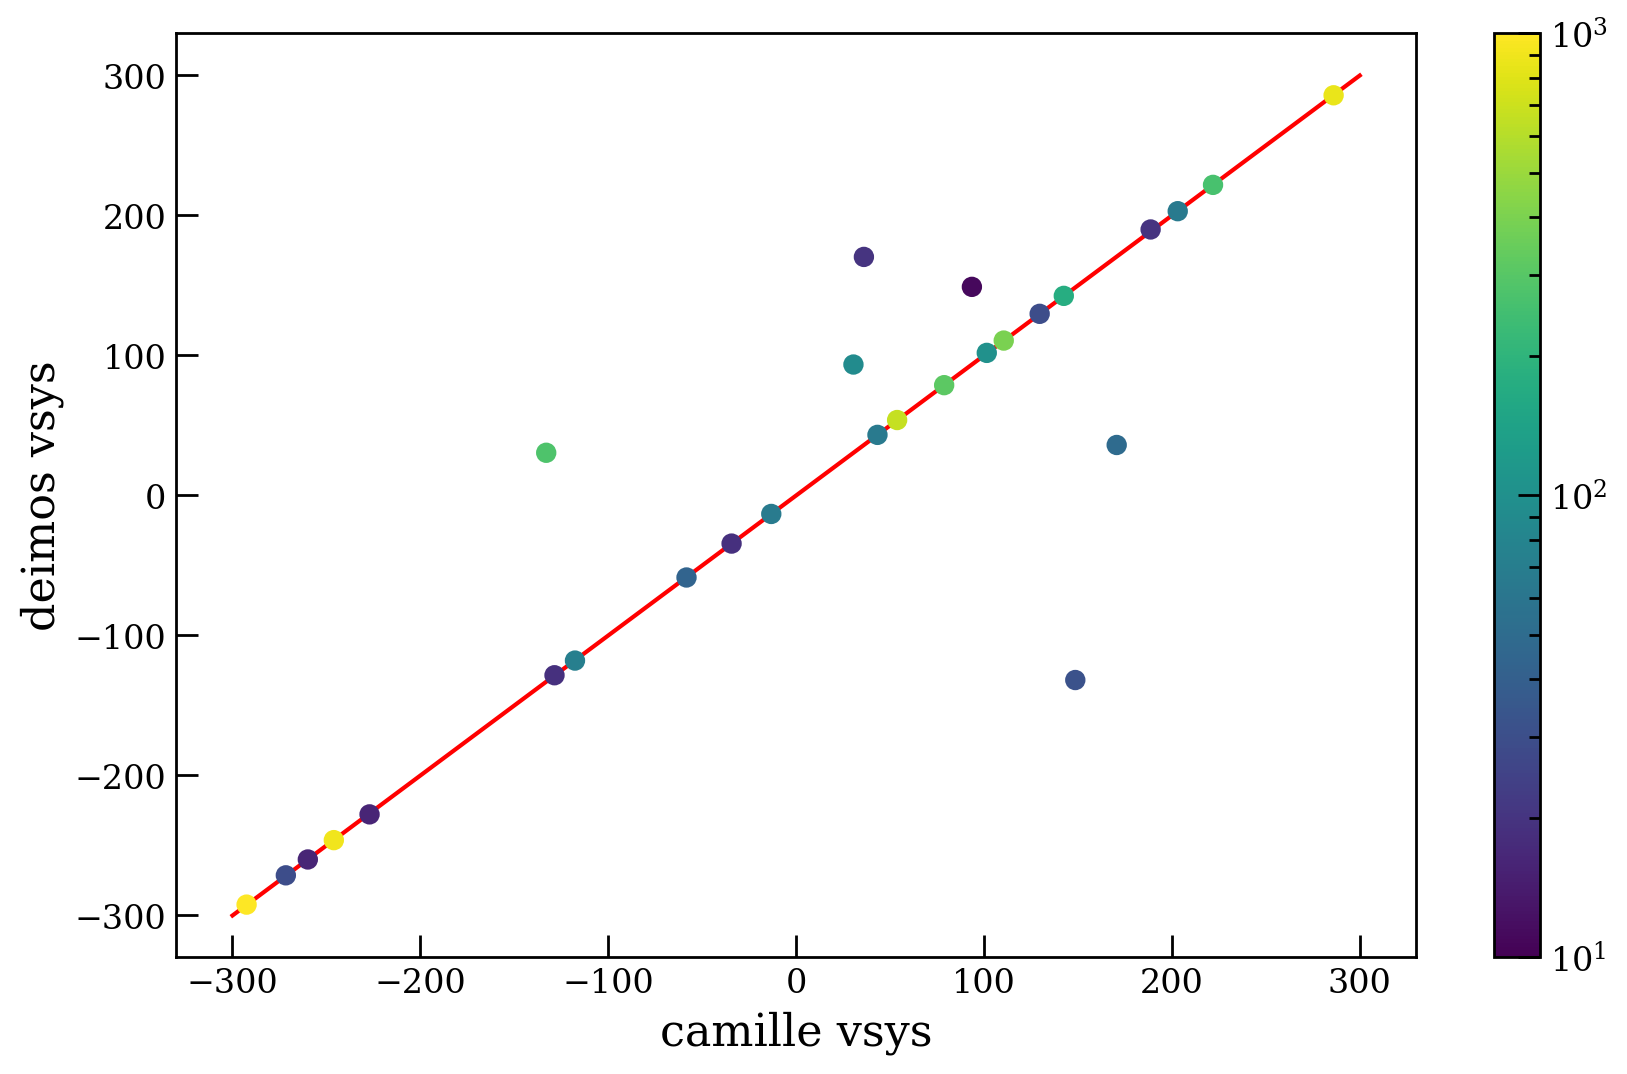

In [359]:
from matplotlib.colors import LogNorm

plt.errorbar(systems["2vsys"], systems["vhel"], xerr = np.array([systems["2vsys_ep"], systems["2vsys_em"]]), 
             yerr = systems["vhelerr"], fmt = "o", c = "black", ms = 2, zorder = 0)
plt.scatter(systems["2vsys"], systems["vhel"], c = systems["N_mem"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([-300, 300], [-300, 300], c = "red", zorder = 0)
plt.xlabel("camille vsys")
plt.ylabel("deimos vsys")
plt.colorbar()

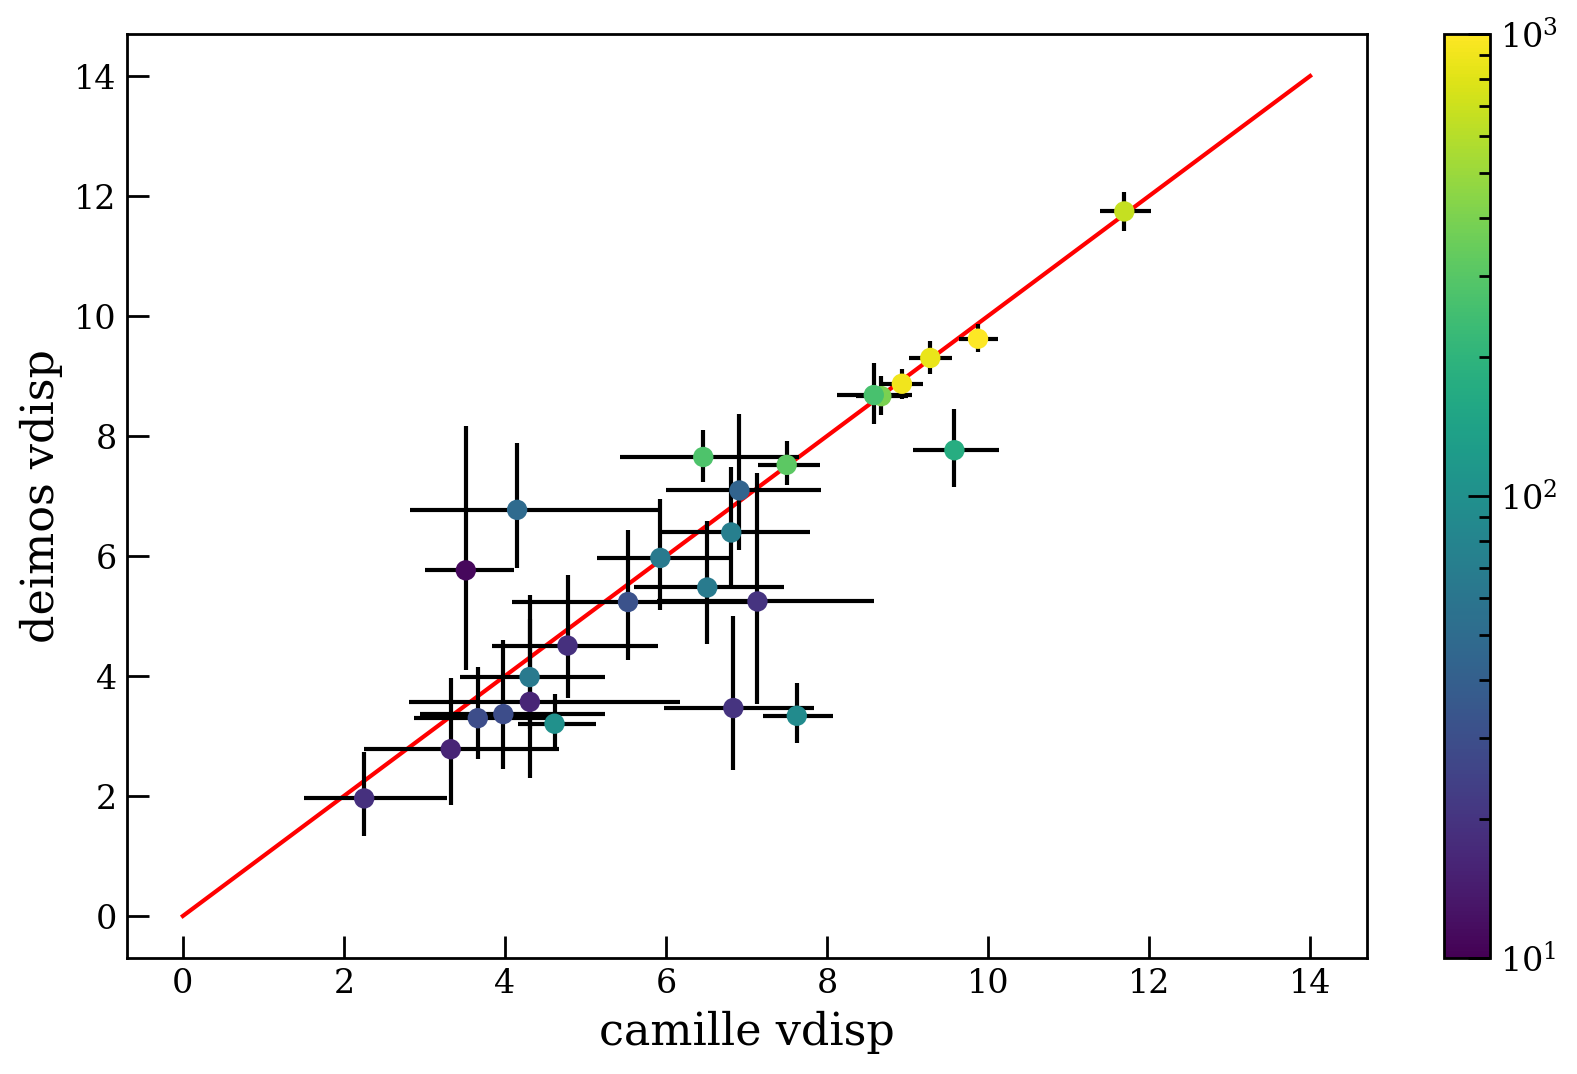

In [360]:
from matplotlib.colors import LogNorm

plt.errorbar(systems["2vdisp"], systems["sigma"], xerr = np.array([systems["2vdisp_ep"], systems["2vdisp_em"]]), 
             yerr = np.array([systems["serr_low"], systems["serr_up"]]), fmt = "o", c = "black", ms = 2, zorder = 1)
plt.scatter(systems["2vdisp"], systems["sigma"], c = systems["N_mem"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([0, 14], [0, 14], c = "red", zorder = 0)
plt.xlabel("camille vdisp")
plt.ylabel("deimos vdisp")
plt.colorbar()

### 3. Add MW foreground contamination fraction

In [410]:
def velocity_mcmc3(vels, v_errs, galaxy_ids, draws = 2000, tune = 100):
    n_galaxies = np.unique(galaxy_ids).size

    with pymc.Model() as model:
        # 1) Population hyperparameters
        mu_vr = pymc.Normal("mu_vr", mu = 0, sigma = 300)                     # mean of global systemic velocity distribution
        log_tau_vr = pymc.Uniform("log_tau_vr", lower = np.log(50), upper = np.log(200))
        tau_vr = pymc.Deterministic("tau_vr", pymc.math.exp(log_tau_vr))     # population scatter in global systemic velocity distribution

        mu_sig = pymc.TruncatedNormal("mu_sig", mu = 6, sigma = 2, lower = 0, upper = 15)    # mean of velocity dispersion distribution
        log_tau_sig = pymc.Uniform("log_tau_sig", lower = np.log(1), upper = np.log(10))     # population scatter in velocity dispersion distribution
        tau_sig = pymc.Deterministic("tau_sig", pymc.math.exp(log_tau_sig))

        # 2) Galaxy parameters
        v_r = pymc.Normal("v_r", mu = mu_vr, sigma = tau_vr, shape = n_galaxies)
        sigma_v = pymc.Normal("sigma_v", mu = mu_sig, sigma = tau_sig, shape = n_galaxies)

        # 3) Milky Way foreground
        mu_mw = pymc.Normal("mu_mw", mu = 0, sigma = 50)
        log_tau_mw = pymc.Uniform("log_tau_mw", lower = np.log(10), upper = np.log(200))
        tau_mw = pymc.Deterministic("tau_mw", pymc.math.exp(log_tau_mw))

        # contamination fraction
        alpha_f = pymc.Exponential("alpha_f", 1)
        beta_f = pymc.Exponential("beta_f", 4)
        f_mw = pymc.Beta("f_mw", alpha = alpha_f, beta = beta_f, shape = n_galaxies)

        ### likelihood ###
        verr_dwarf = np.sqrt(v_errs**2 + sigma_v[galaxy_ids]**2)
        lnl_dwarf = pymc.Normal.dist(mu = v_r[galaxy_ids], sigma = verr_dwarf)

        verr_mw = np.sqrt(v_errs**2 + tau_mw**2)
        lnl_mw = pymc.Normal.dist(mu = mu_mw, sigma = verr_mw)

        pymc.Mixture("obs", w = pymc.math.stack([1 - f_mw[galaxy_ids], f_mw[galaxy_ids]], axis = 1), 
                     comp_dists = [lnl_dwarf, lnl_mw], observed = vels)

        # sampling
        trace = pymc.sample(draws=draws, tune=tune, chains = 1, target_accept = 0.95, 
                            return_inferencedata = True, progressbar = True)

    # population
    posterior = trace.posterior

    mu_vr_vals = np.percentile(posterior["mu_vr"].values.flatten(), [16, 50, 84])
    tau_vr_vals = np.percentile(posterior["tau_vr"].values.flatten(), [16, 50, 84])
    mu_sig_vals = np.percentile(posterior["mu_sig"].values.flatten(), [16, 50, 84])
    tau_sig_vals = np.percentile(posterior["tau_sig"].values.flatten(), [16, 50, 84])
    mu_mw_vals = np.percentile(posterior["mu_mw"].values.flatten(), [16, 50, 84])
    sigma_mw_vals = np.percentile(posterior["tau_mw"].values.flatten(), [16, 50, 84])

    # galaxies
    v_r_samples = posterior["v_r"].values
    sigma_v_samples = posterior["sigma_v"].values
    f_mw_samples = posterior["f_mw"].values

    n_galaxies = v_r_samples.shape[2]
    v_r_percentiles = np.zeros((n_galaxies, 3)) 
    sigma_v_percentiles = np.zeros((n_galaxies, 3))
    f_percentiles = np.zeros((n_galaxies, 3))

    for ii in range(n_galaxies):
        v_r_percentiles[ii] = np.percentile(v_r_samples[:, :, ii].flatten(), [16, 50, 84])
        sigma_v_percentiles[ii] = np.percentile(sigma_v_samples[:, :, ii].flatten(), [16, 50, 84])
        f_percentiles[ii] = np.percentile(f_mw_samples[:, :, ii].flatten(), [16, 50, 84])

    return model, trace, summary, [mu_vr_vals, tau_vr_vals], [mu_sig_vals, tau_sig_vals], [mu_mw_vals, sigma_mw_vals], f_percentiles, v_r_percentiles, sigma_v_percentiles

In [ ]:
gals = stars[(stars["Pmem"] > 0.5) & (stars["Var"] != 1) & (stars["rhalf"] <= 2)] # & (stars["Galaxy_idx"] <= 5)
model, trace, summary, vr_vals, sig_vals, mw_vals, f_percentiles, v_r_percentiles, sigma_v_percentiles = velocity_mcmc3(gals["v"].values, gals["verr"].values, gals["Galaxy_idx"].values)

Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (1 chains in 1 job)
NUTS: [mu_vr, log_tau_vr, mu_sig, log_tau_sig, v_r, sigma_v, mu_mw, log_tau_mw, alpha_f, beta_f, f_mw]
INFO:pymc.sampling.mcmc:NUTS: [mu_vr, log_tau_vr, mu_sig, log_tau_sig, v_r, sigma_v, mu_mw, log_tau_mw, alpha_f, beta_f, f_mw]


Output()

Sampling 1 chain for 100 tune and 2_000 draw iterations (100 + 2_000 draws total) took 241 seconds.
INFO:pymc.sampling.mcmc:Sampling 1 chain for 100 tune and 2_000 draw iterations (100 + 2_000 draws total) took 241 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO:pymc.stats.convergence:Only one chain was sampled, this makes it impossible to run some convergence checks


In [413]:
vsys_3    = v_r_percentiles[:, 1]
vsys_3ep = v_r_percentiles[:, 1] - v_r_percentiles[:, 0]
vsys_3em = v_r_percentiles[:, 2] - v_r_percentiles[:, 1]

vdisp_3    = sigma_v_percentiles[:, 1]
vdisp_3ep = sigma_v_percentiles[:, 1] - sigma_v_percentiles[:, 0]
vdisp_3em = sigma_v_percentiles[:, 2] - sigma_v_percentiles[:, 1]

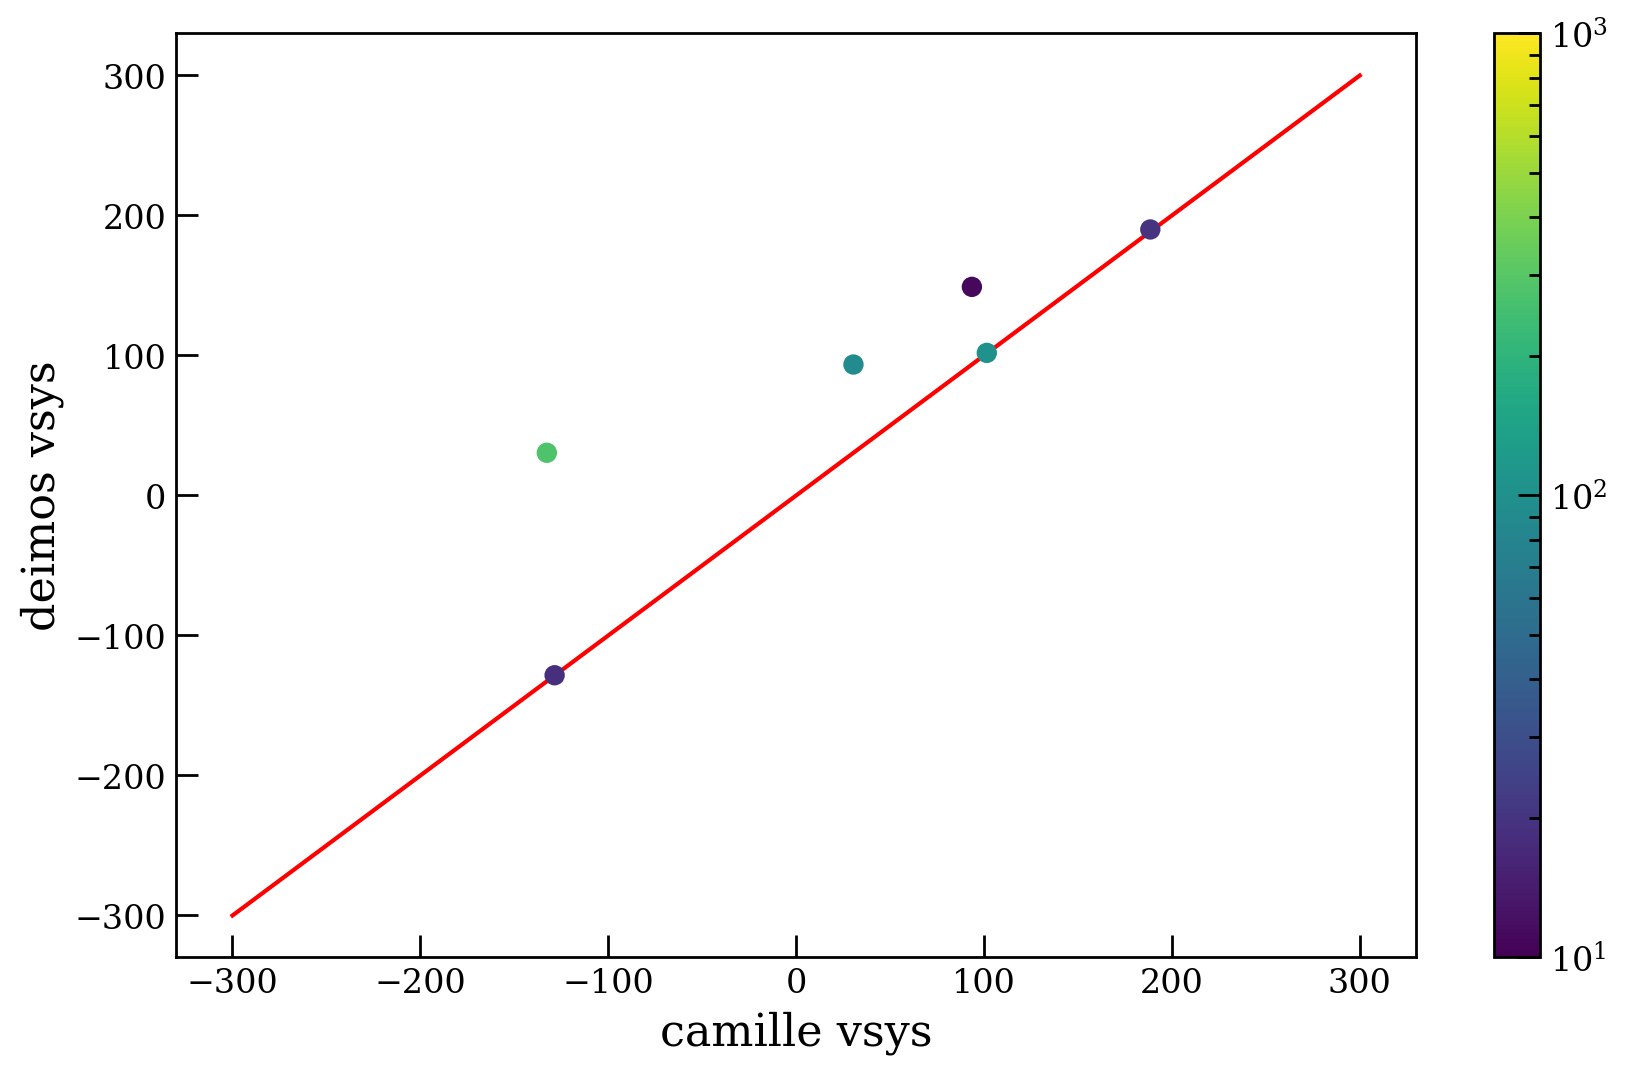

In [ ]:
mask = systems["Galaxy_idx"] <= 5
plt.errorbar(vsys_3, systems[mask]["vhel"], xerr = np.array([vsys_3ep, vsys_3em]), 
             yerr = systems[mask]["vhelerr"], fmt = "o", c = "black", ms = 2, zorder = 0)
plt.scatter(vsys_3, systems[mask]["vhel"], c = systems[mask]["N_mem"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([-300, 300], [-300, 300], c = "red", zorder = 0)
plt.xlabel("camille vsys")
plt.ylabel("deimos vsys")
plt.colorbar()

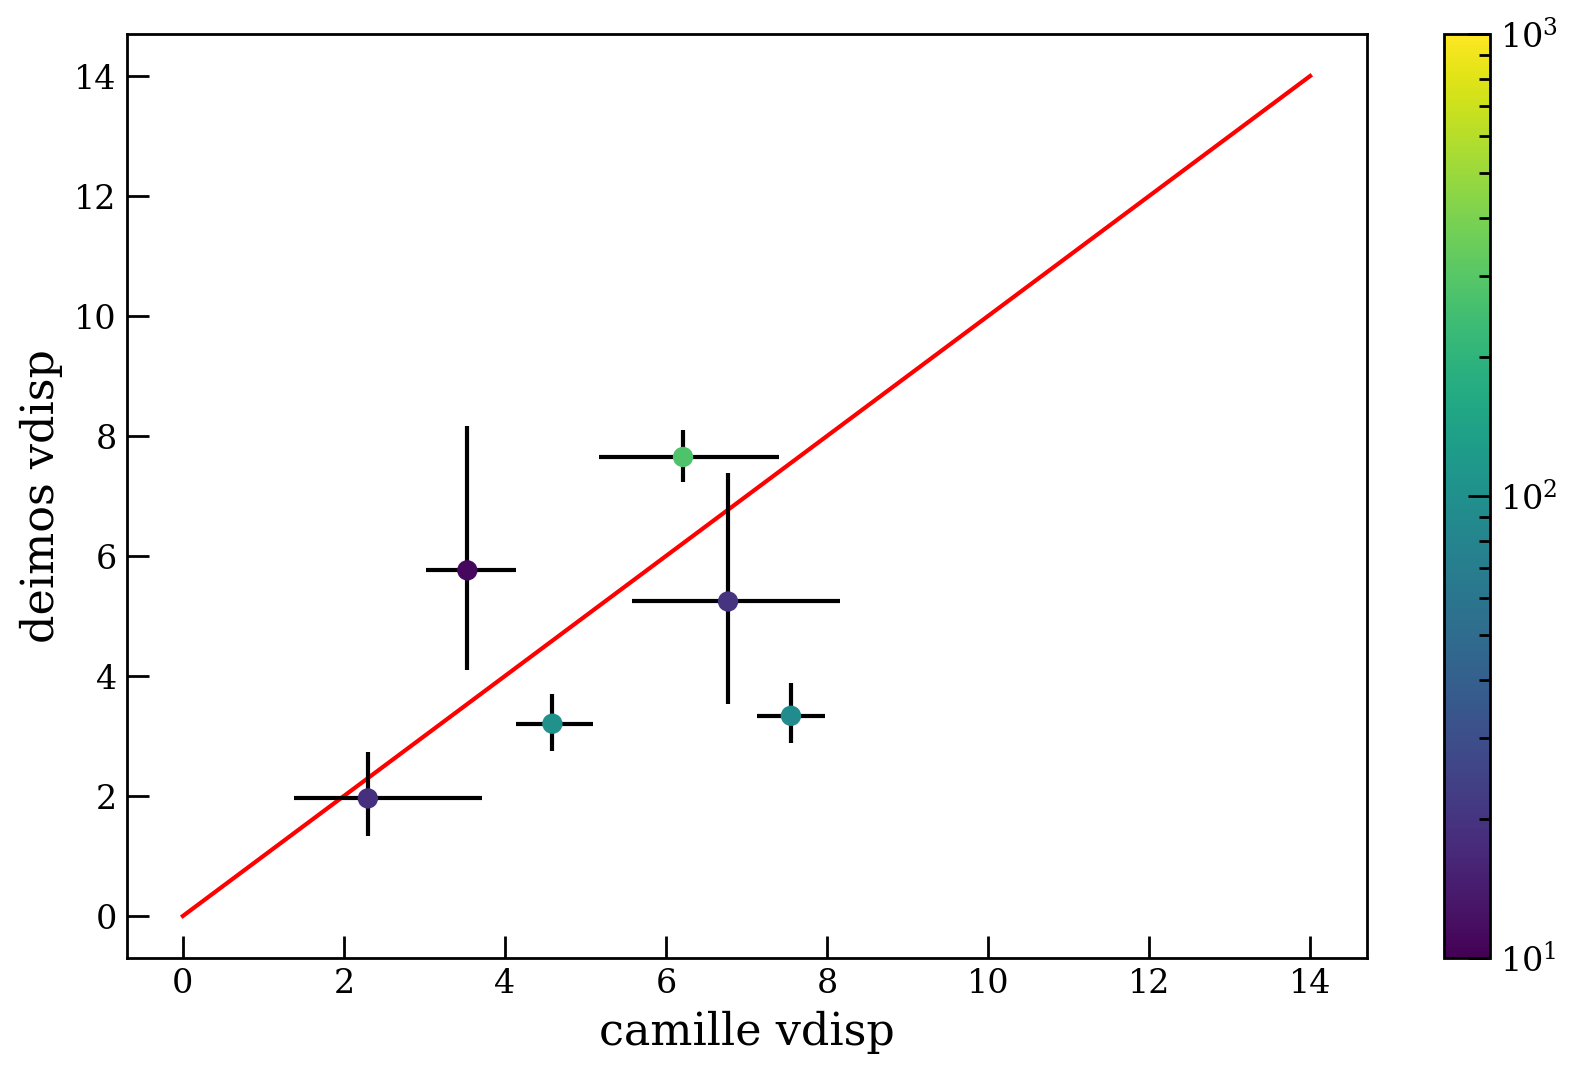

In [415]:
plt.errorbar(vdisp_3, systems[mask]["sigma"], xerr = np.array([vdisp_3ep, vdisp_3em]), 
             yerr = np.array([systems[mask]["serr_low"], systems[mask]["serr_up"]]), fmt = "o", c = "black", ms = 2, zorder = 1)
plt.scatter(vdisp_3, systems[mask]["sigma"], c = systems[mask]["N_mem"], cmap = "viridis", norm = LogNorm(10, 1e3), zorder = 2, s = 40)
plt.plot([0, 14], [0, 14], c = "red", zorder = 0)
plt.xlabel("camille vdisp")
plt.ylabel("deimos vdisp")
plt.colorbar()

probabilistic graphical models

### 4. Adding velocity variables

In [ ]:
def velocity_mcmc4(vels, v_errs, galaxy_ids, star_ids, draws = 4000, tune = 2000):
    n_galaxies = np.size(np.unique(galaxy_ids))
    n_stars = np.size(np.unique(star_ids))

    with pymc.Model() as model:
        # 1) Population hyperparameters
        mu_vr = pymc.Normal("mu_vr", mu = 0, sigma = 25)                     # mean of global systemic velocity distribution
        log_tau_vr = pymc.Uniform("log_tau_vr", lower = np.log(50), upper = np.log(200))
        tau_vr = pymc.Deterministic("tau_vr", pymc.math.exp(log_tau_vr))     # population scatter in global systemic velocity distribution

        mu_sig = pymc.TruncatedNormal("mu_sig", mu = 6, sigma = 3, lower = 0, upper = 20)      # mean of velocity dispersion distribution
        log_tau_sig = pymc.Uniform("log_tau_sig", lower = np.log(0.1), upper = np.log(10))     # population scatter in velocity dispersion distribution
        tau_sig = pymc.Deterministic("tau_sig", pymc.math.exp(log_tau_sig))

        # 2) Galaxy parameters
        v_r = pymc.Normal("v_r", mu = mu_vr, sigma = tau_vr, shape = n_galaxies)
        sigma_v = pymc.Normal("sigma_v", mu = mu_sig, sigma = tau_sig, shape = n_galaxies)

        # 3) Milky Way foreground
        mu_mw = pymc.Normal("mu_mw", mu = 0, sigma = 200)
        sigma_mw = pymc.HalfNormal("sigma_mw", sigma = 100)

        # contamination fraction
        alpha_f = pymc.Exponential("alpha_f", 1)
        beta_f = pymc.Exponential("beta_f", 4)
        f_mw = pymc.Beta("f_mw", alpha = alpha_f, beta = beta_f, shape = n_galaxies)

        # 4) binary star fraction
        f_binary = pymc.Beta("f_binary", alpha = 1, beta = 4, shape = n_galaxies)
        log_sigma_binary = pymc.Uniform("log_sigma_binary", lower = np.log(0.1), upper = np.log(50), shape = n_stars)
        sigma_binary = pymc.Deterministic("sigma_binary", pymc.math.exp(log_sigma_binary))

        true_v = pymc.Normal("true_v", mu = v_r[galaxy_ids], sigma = sigma_v[galaxy_ids], shape = n_stars)
        
        # binary mixture
        single_stars = pymc.Normal.dist(mu = true_v, sigma = v_errs, shape = n_stars)
        binary_stars = pymc.Normal.dist(mu = true_v, sigma = np.sqrt(v_errs**2 + sigma_binary**2), shape = n_stars)
        lnl_dwarf = pymc.Mixture.dist(w = pymc.math.stack([1-f_binary[galaxy_ids], f_binary[galaxy_ids]], axis = 1), 
                                           comp_dists = [single_stars, binary_stars])
        
        # mw mixture
        verr_mw = np.sqrt(v_errs**2 + sigma_mw**2)
        lnl_mw = pymc.Normal.dist(mu = mu_mw, sigma = verr_mw)

        ### likelihood ###
        pymc.Mixture("obs", w = pymc.math.stack([1 - f_mw[galaxy_ids], f_mw[galaxy_ids]], axis = 1), 
                     comp_dists = [lnl_dwarf, lnl_mw], observed = vels)

        # sampling
        trace = pymc.sample(draws=draws, tune=tune, chains = 1, target_accept = 0.9, 
                            return_inferencedata = True, progressbar = True)

    # population
    posterior = trace.posterior

    mu_vr_vals = np.percentile(posterior["mu_vr"].values.flatten(), [16, 50, 84])
    tau_vr_vals = np.percentile(posterior["tau_vr"].values.flatten(), [16, 50, 84])
    mu_sig_vals = np.percentile(posterior["mu_sig"].values.flatten(), [16, 50, 84])
    tau_sig_vals = np.percentile(posterior["tau_sig"].values.flatten(), [16, 50, 84])
    mu_mw_vals = np.percentile(posterior["mu_mw"].values.flatten(), [16, 50, 84])
    sigma_mw_vals = np.percentile(posterior["sigma_mw"].values.flatten(), [16, 50, 84])

    # galaxies
    v_r_samples = posterior["v_r"].values
    sigma_v_samples = posterior["sigma_v"].values

    n_galaxies = v_r_samples.shape[2]
    v_r_percentiles = np.zeros((n_galaxies, 3)) 
    sigma_v_percentiles = np.zeros((n_galaxies, 3))

    for ii in range(n_galaxies):
        v_r_percentiles[ii] = np.percentile(v_r_samples[:, :, ii].flatten(), [16, 50, 84])
        sigma_v_percentiles[ii] = np.percentile(sigma_v_samples[:, :, ii].flatten(), [16, 50, 84])

    summary = arviz.summary(trace)

    return model, trace, summary, [mu_vr_vals, tau_vr_vals], [mu_sig_vals, tau_sig_vals], [mu_mw_vals, sigma_mw_vals], v_r_percentiles, sigma_v_percentiles

In [ ]:
gals = stars[(stars["Pmem"] > 0.5) & (stars["Var"] != 1) & (stars["rhalf"] <= 2) & (stars["Galaxy_idx"] < 10)]
model, trace, summary, vr_vals, sig_vals, mw_vals, v_r_percentiles, sigma_v_percentiles = velocity_mcmc3(gals["v"].values, gals["verr"].values, gals["Galaxy_idx"].values)